In [5]:
import pandas as pd
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import os

os.environ["WANDB_DISABLED"] = "true"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using NVIDIA GPU (CUDA)


## Data Loading and Initial Cleaning

In [ ]:
csv_path = "../dataset/OBC_Cleaned.csv"
df = pd.read_csv(csv_path)

df = df.dropna(how="all")

print("Initial dataset shape:", df.shape)
print("\nVerdict distribution:")
print(df["Verdict"].value_counts())
print("\nOffence distribution:")
print(df["Offence"].value_counts())
print("\nYear distribution:")
print(df["Year"].value_counts().sort_index())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial dataset shape: (49365, 6)

Verdict distribution:
Verdict
guilty       35487
notGuilty    13878
Name: count, dtype: int64

Offence distribution:
Offence
theft            37033
deception         2956
violentTheft      2433
royalOffences     2135
sexual            1434
breakingPeace     1319
kill              1205
miscellaneous      654
damage             196
Name: count, dtype: int64

Year distribution:
Year
1720    210
1721    370
1722    320
1723    260
1724    449
       ... 
1909     63
1910    206
1911    204
1912    189
1913    151
Name: count, Length: 174, dtype: int64


## Data Preprocessing

In [ ]:
df = df.drop_duplicates(subset="Trial_ID", keep="first")
df = df.drop_duplicates(subset="Trial_Text", keep="first")
df = df.drop(columns=["Date"])
df = df[df["Offence"] != "Unknown"]

print("After removing duplicates and unknowns:", df.shape)
print("\nVerdict distribution:")
print(df["Verdict"].value_counts())
print("\nOffence distribution:")
print(df["Offence"].value_counts())

After removing duplicates and unknowns: (49365, 5)

Verdict distribution:
Verdict
guilty       35487
notGuilty    13878
Name: count, dtype: int64

Offence distribution:
Offence
theft            37033
deception         2956
violentTheft      2433
royalOffences     2135
sexual            1434
breakingPeace     1319
kill              1205
miscellaneous      654
damage             196
Name: count, dtype: int64


## Balance Dataset

In [ ]:
df_not_guilty = df[df['Verdict'] == 'notGuilty'].copy()
df_guilty = df[df['Verdict'] == 'guilty'].copy()

total_not_guilty = len(df_not_guilty)
total_guilty = len(df_guilty)

print("Before balancing:")
print(f"Total notGuilty: {total_not_guilty}")
print(f"Total guilty: {total_guilty}")
print(f"Difference: {abs(total_not_guilty - total_guilty)}\n")

if total_guilty > total_not_guilty:
    df_guilty_sampled = df_guilty.sample(n=total_not_guilty, random_state=42)
    df = pd.concat([df_not_guilty, df_guilty_sampled])
elif total_not_guilty > total_guilty:
    df_not_guilty_sampled = df_not_guilty.sample(n=total_guilty, random_state=42)
    df = pd.concat([df_not_guilty_sampled, df_guilty])
else:
    df = pd.concat([df_not_guilty, df_guilty])

print("After balancing:")
print(df["Verdict"].value_counts())

Before balancing:
Total notGuilty: 13878
Total guilty: 35487
Difference: 21609

After balancing:
Verdict
notGuilty    13878
guilty       13878
Name: count, dtype: int64


## Text Cleaning Pipeline

In [ ]:
def clean_text_pipeline(text):
    """Apply all text cleaning steps in sequence"""
    text = str(text)

    text = re.sub(r'^[\W\d\s]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'[+*FO]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if pd.notna(text):
        text = re.sub(r'(?<=\w)\.(?=[A-Z])', '. ', text)
        text = re.sub(r'\s+([.,!?])', r'\1', text)
        text = re.sub(r"Prisoner s", "Prisoner's", text)
        text = re.sub(r'(\d+)\s*d\s*\.', r'\1d.', text)

    return text.strip()

df['Trial_Text'] = df['Trial_Text'].apply(clean_text_pipeline)
print("Text cleaning complete")
print(f"Sample cleaned text:\n{df['Trial_Text'].iloc[0][:200]}...")

Text cleaning complete
Sample cleaned text:
John Bowen was indicted for that he on the 24th of ebruary between the hour of twelve and one in the morning the dwelling house of William Gwinn did break and enter and stealing out thence twenty yard...


## NLP Preprocessing (Tokenization, Lemmatization, Stopword Removal)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk_data_dir = "../data-parsing/nltk_data"
nltk.data.path.append(nltk_data_dir)
os.makedirs(nltk_data_dir, exist_ok=True)

for resource in ['punkt', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger_eng', 'stopwords']:
    nltk.download(resource, download_dir=nltk_data_dir, quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    try:
        if not isinstance(text, str):
            return ""

        text = re.sub(r'^\s*[TM]\.\s*', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)

        sentences = sent_tokenize(text)
        cleaned_sentences = []

        for sentence in sentences:
            words = word_tokenize(sentence.lower())
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            lemmatized_words = [
                lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                for word, tag in tagged_words
            ]
            cleaned_sentences.append(" ".join(lemmatized_words))

        return " ".join(cleaned_sentences)

    except Exception as e:
        print(f"] Failed to process text: {e}")
        return text

print("Applying NLP preprocessing (this may take a while)...")
df["Trial_Text"] = df["Trial_Text"].astype(str).apply(preprocess_text)
print("NLP preprocessing complete")
print(f"Sample preprocessed text:\n{df['Trial_Text'].iloc[0][:200]}...")

Streaming output truncated to the last 5000 lines.
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '../data-parsing/nltk_data'
**********************************************************************

[ERROR] Failed to process text: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '../data-parsing/nltk_data'
**********************************************************************

[ERROR] Failed to process text: 
*******************************************

## Prepare Data for Model Training

In [ ]:
df = df[df["Verdict"].isin(["guilty", "notGuilty"])]

label_map = {"guilty": 1, "notGuilty": 0}
df["Label"] = df["Verdict"].map(label_map)
df["Formatted_Text"] = df.apply(lambda row: f"Year: {row['Year']} Text: {row['Trial_Text']}", axis=1)

print(f"Final dataset shape: {df.shape}")
print(f"Label distribution:\n{df['Label'].value_counts()}")

Final dataset shape: (27756, 7)
Label distribution:
Label
0    13878
1    13878
Name: count, dtype: int64


## Define Dataset and Metrics

In [12]:
class CourtDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

## Initialize Tokenizer and Cross-Validation

In [13]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_fold = -1
best_model = None
best_tokenizer = None
best_val_acc = 0.0
train_acc_all, val_acc_all = [], []
train_loss_all, val_loss_all = [], []

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

## 10-Fold Cross-Validation Training


Fold 1


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.569200,0.294213,0.842219
2,0.279300,0.224446,0.872118
3,0.239700,0.231658,0.864914
4,0.218800,0.211654,0.877882
5,0.195700,0.219380,0.880764


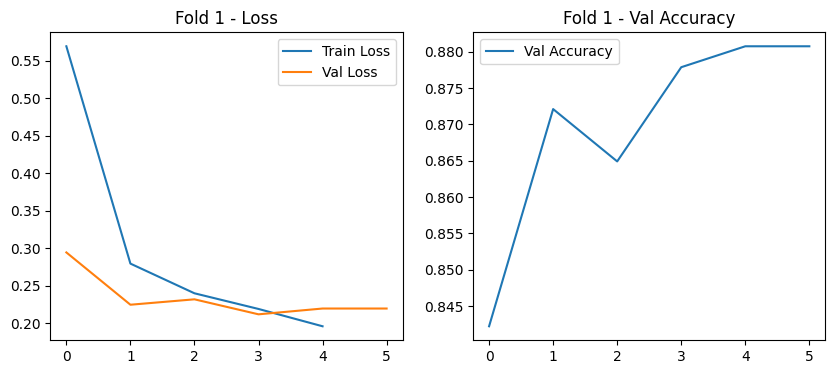


Fold 2


In [ ]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(df["Formatted_Text"], df["Label"])):
    print(f"\nFold {fold+1}")

    train_texts = df.iloc[train_idx]["Formatted_Text"].tolist()
    train_labels = df.iloc[train_idx]["Label"].tolist()
    val_texts = df.iloc[val_idx]["Formatted_Text"].tolist()
    val_labels = df.iloc[val_idx]["Label"].tolist()

    train_dataset = CourtDataset(train_texts, train_labels, tokenizer)
    val_dataset = CourtDataset(val_texts, val_labels, tokenizer)

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

    training_args = TrainingArguments(
        output_dir=f"./temp_fold_{fold}",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=16,
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=2e-5,
        report_to="none",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        warmup_steps=500,
        load_best_model_at_end=False,
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    metrics = trainer.evaluate()
    val_acc_all.append(metrics["eval_accuracy"])
    val_loss_all.append(metrics["eval_loss"])

    logs = trainer.state.log_history
    train_loss = [log["loss"] for log in logs if "loss" in log]
    val_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
    val_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
    train_acc = [log["train_accuracy"] for log in logs if "train_accuracy" in log]

    train_acc_all.append(logs[-1].get("accuracy", np.nan))
    train_loss_all.append(train_loss[-1] if train_loss else np.nan)

    if fold == 9:
        best_val_acc = metrics["eval_accuracy"]
        best_fold = fold
        best_model = model
        best_tokenizer = tokenizer

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    if train_acc:
        plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Val Accuracy")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    del model
    torch.cuda.empty_cache()


## Save Best Model

In [ ]:
final_model_path = "../models/roberta_final_best_model"
os.makedirs(final_model_path, exist_ok=True)
best_model.save_pretrained(final_model_path)
best_tokenizer.save_pretrained(final_model_path)
print(f"Model saved to {final_model_path}")

## Final Results

In [ ]:
print(f"\nFinal model saved from best fold: {best_fold + 1}")
print(f"Mean Validation Accuracy (10-fold): {np.mean(val_acc_all):.4f}")
print(f"Mean train loss (10-fold): {np.mean(train_loss_all):.4f}")
print(f"Mean val loss (10-fold): {np.mean(val_loss_all):.4f}")

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset
import os

os.environ["WANDB_DISABLED"] = "true"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/OBC_Cleaned.csv")
df = df.dropna(subset=["Trial_Text", "Verdict"])

print(f"Loaded {len(df)} rows")
print(f"Columns: {list(df.columns)}")
print(f"\nVerdict distribution:\n{df['Verdict'].value_counts()}")
print(f"\nSample text: {df['Trial_Text'].iloc[0][:200]}...")

In [ ]:
df_not_guilty = df[df['Verdict'] == 'notGuilty']
df_guilty = df[df['Verdict'] == 'guilty']

min_count = min(len(df_not_guilty), len(df_guilty))
print(f"Balancing to {min_count} samples per class")

df = pd.concat([
    df_not_guilty.sample(n=min_count, random_state=42),
    df_guilty.sample(n=min_count, random_state=42)
])

df = df.drop_duplicates(subset="Trial_ID", keep="first")

print(f"\nBalanced dataset: {len(df)} rows")
print(df['Verdict'].value_counts())

In [ ]:
label_map = {"guilty": 1, "notGuilty": 0}
df["Label"] = df["Verdict"].map(label_map)

df["Formatted_Text"] = df.apply(
    lambda row: (
        f"Year: {row['Year']} "
        f"Defendant Gender: {row.get('Defendant_Gender', 'Unknown')} "
        f"Number of Defendants: {row.get('Num_Defendants', 'Unknown')} "
        f"Victim Gender: {row.get('Victim_Gender', 'Unknown')} "
        f"Number of Victims: {row.get('Num_Victims', 'Unknown')} "
        f"Offence: {row['Offence']} "
        f"Offence Subcategory: {row.get('Offence_Subcategory', 'Unknown')} "
        f"Text: {row['Trial_Text']}"
    ),
    axis=1
)

print(f"Total samples: {len(df)}")
print(f"Label distribution:\n{df['Label'].value_counts()}")
print(f"\nSample formatted text:\n{df['Formatted_Text'].iloc[0][:400]}...")

In [ ]:
class CourtDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=1)
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc}

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Formatted_Text"].tolist(),
    df["Label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["Label"]
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

In [ ]:
train_dataset = CourtDataset(train_texts, train_labels, tokenizer)
val_dataset = CourtDataset(val_texts, val_labels, tokenizer)

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./temp_model",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    report_to="none",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    use_cpu=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

print("Starting training...")
trainer.train()

print("\nEvaluating model...")
metrics = trainer.evaluate()

logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
val_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
val_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label="Val Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
final_model_path = "./roberta_model"
os.makedirs(final_model_path, exist_ok=True)
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

In [ ]:
print("\n" + "="*60)
print("STANDARD MODEL - TRAINING RESULTS")
print("="*60)
print(f"\nValidation Accuracy: {metrics['eval_accuracy']:.4f}")

print(f"Validation Loss: {metrics['eval_loss']:.4f}")

print(f"\nModel saved to {final_model_path}")